In [160]:
import cv2
import datetime
import descarteslabs as dl
import descarteslabs.workflows as wf
import glob
import json
import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import os
from osgeo import gdal

In [2]:
# focus on Bengkala site for now
input_dir = '../data/s2/TPA_Bengkala'
input_files = glob.glob(os.path.join(input_dir, '*.tif'))
print('Found {} files'.format(len(input_files)))

Found 345 files


In [3]:
# sort files by date
def sort_by_date(f):
    date_str = os.path.basename(f).split('_')[-2]
    dtime = datetime.datetime.strptime(date_str, '%Y%m%dT%H%M%S')
    return dtime

input_files = sorted(input_files, key=sort_by_date)

In [38]:
# look at a single file
arr = gdal.Open(input_files[0]).ReadAsArray()

In [63]:
def center_crop(img, dim):
    '''
    center crop an image with a fixed width
    preserves all input channels
    '''
    
    width, height = img.shape[2], img.shape[1]
    crop_width = dim[0] if dim[0] < width else width
    crop_height = dim[1] if dim[1] < height else height
    
    mid_x, mid_y = int(width / 2), int(height / 2)
    cw2, ch2 = int(crop_width / 2), int(crop_height / 2)
    
    img_crop = img[:, mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    
    return img_crop

In [90]:
def load_stack(input_files, cloudy_pct=50, cloud_thresh=65, dim=(100,100)):
    '''
    load a stack of imagery into memory
    don't keep scenes that are cloudy
    '''
    
    stack = list()
    dates = list()
    for input_file in input_files:
        arr = gdal.Open(input_file).ReadAsArray()
        cloudy = arr[-1, :, :] >= cloud_thresh
        
        pct = (np.count_nonzero(cloudy) / cloudy.size) * 100
        if pct > cloudy_pct:
            continue
        else:
            stack.append(center_crop(arr, dim))
            dates.append(sort_by_date(input_file).strftime('%Y-%m-%d'))
            
    stack = np.stack(stack)
    print('Filtered down to {} images'.format(len(stack)))
    return stack, dates

In [75]:
def rescale_img(img, min_val=0.0, max_val=1.0, dtype=np.float32, pmin=0.0, pmax=100.0):
    """
    Return a scaled image between [0, 255] regardless of input scaling.

    Parameters
    ----------
    img: np.array
        Image as NumPy array
    min_val: float
        Minimum value of rescaled image (default 0.0)
    max_val: float
        Maximum value of rescaled image (default 1.0)
    dtype : np.dtype
        Type to return rescaled image (default np.float32)
    pmin : float
        Minimum percentage of values for scaling (default 0%)
    pmax : float
        Maximum percentage of values for scaling (default 100%)

    Returns
    -------
    img_rescale: np.array
        Image as NumPy array

    """

    # compute min and max percentile ranges to scale with
    vmin, vmax = np.nanpercentile(img, pmin), np.nanpercentile(img, pmax)

    # rescale & clip
    img_rescale = ((img - vmin) * (1.0 / (vmax - vmin) * max_val)).astype(dtype)
    np.clip(img_rescale, min_val, max_val, out=img_rescale)

    return img_rescale

In [88]:
def scale_stack(stack):
    '''
    return scaled stacks with RGB and IR scaling
    '''
    
    rgb_scaled = list()
    ir_scaled = list()
    for img in stack:
        rgb_img = img[0:3, :, :]
        ir_img = np.stack([img[5, :, :], img[4, :, :], img[3, :, :]], axis=0)
        
        rgb_img = rescale_img(rgb_img, pmin=2, pmax=98)
        rgb_img = rescale_img(rgb_img, 0, 255, np.uint8)
                           
        ir_img = rescale_img(ir_img, pmin=2, pmax=98)
        ir_img = rescale_img(ir_img, 0, 255, np.uint8)
                           
        rgb_scaled.append(rgb_img)
        ir_scaled.append(ir_img)
        
    return rgb_scaled, ir_scaled

In [91]:
stack, dates = load_stack(input_files)

Filtered down to 209 images


In [92]:
rgb_scaled, ir_scaled = scale_stack(stack)

In [150]:
final_imgs = list()
for date_str, rgb_img, ir_img in zip(dates, rgb_scaled, ir_scaled):
    final_img = np.transpose(np.concatenate([rgb_img, ir_img], axis=2), (1, 2, 0))
    final_img = cv2.cvtColor(final_img, cv2.COLOR_RGB2BGR)
    final_img = cv2.resize(final_img, (400, 200))
    
    cv2.putText(final_img, date_str, (5, 190), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(final_img, 'True Color', (5, 15), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(final_img, 'Infrared', (205, 15), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255), 1)
    
    final_imgs.append(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

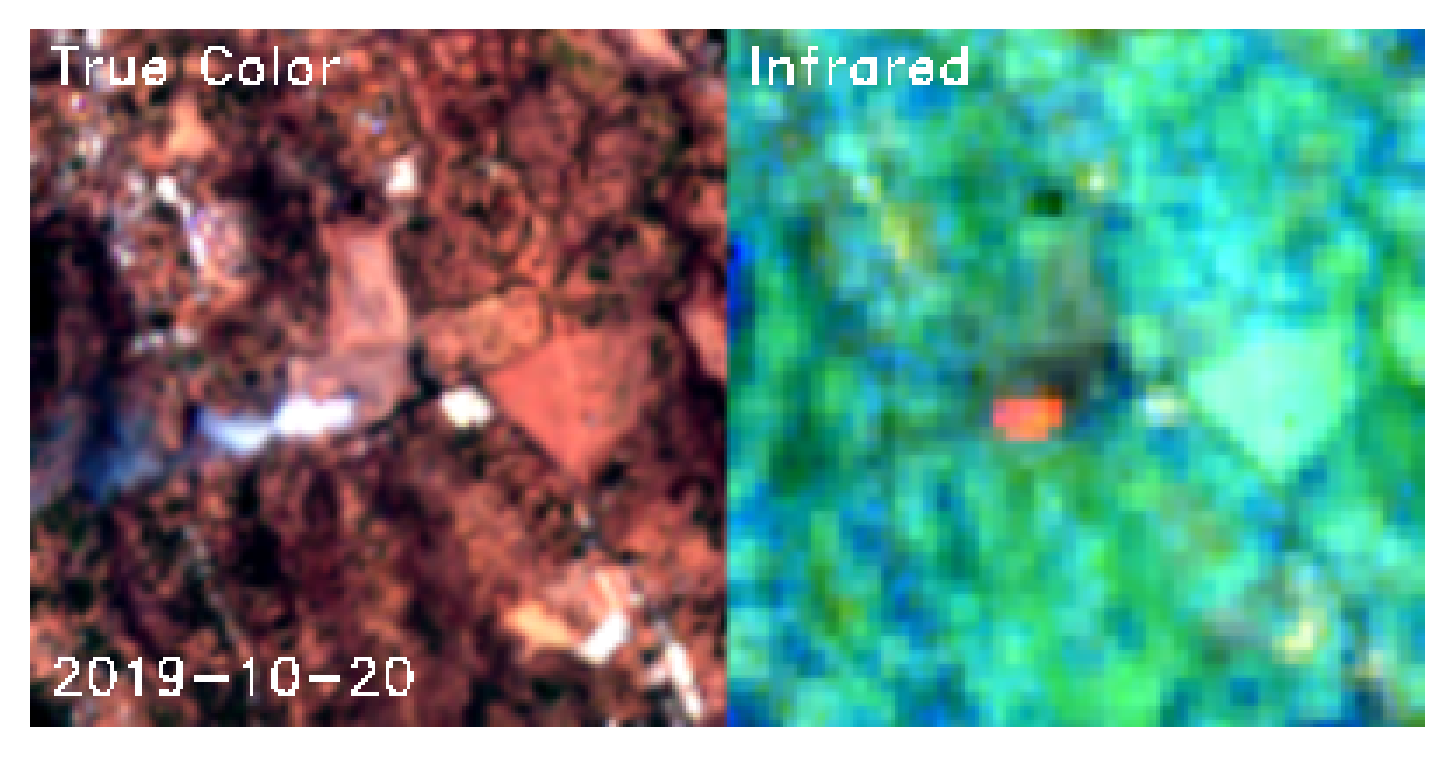

In [195]:
plt.figure(dpi=300)
plt.axis('off')
plt.imshow(final_imgs[-56])

In [146]:
output_dir = '../data/fires/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
outname = os.path.join(output_dir, 'bengkala.gif')

In [196]:
clip = mpy.ImageSequenceClip(final_imgs, fps=3)
clip.write_gif(outname, fps=3, program='ffmpeg')

t:  10%|▉         | 20/210 [00:00<00:01, 162.07it/s, now=None]

MoviePy - Building file  ../data/fires/bengkala.gif
MoviePy - - Generating GIF frames.


MoviePy - - File ready: ../data/fires/bengkala.gif.
